# Sprint
## セグメンテーション2

## 1.このSprintについて

### Sprintの目的
- セグメンテーションの精度を向上させる

### どのように学ぶか
Kaggleコンペティションの情報を参考にセグメンテーションの精度を向上させます。

## 2.セグメンテーションの精度向上

前回に引き続きTGS Salt Identification Challengのデータセットの学習・推定を行います。


[TGS Salt Identification Challenge | Kaggle](https://www.kaggle.com/c/tgs-salt-identification-challenge)

### 【問題1】
#### コードレビュー
転移学習を使用してセグメンテーションの精度を改善したコードを提示するので、レビューを行ってください。


**《視点例》**


- 前回使用した実装とはどのように違うのか
- 転移学習をどのように行っているか

`./03-models_pretrained_and_more.ipynb`を読む。

1. 前回使用した実装との違い
  - 層が多い(エンコーダで50層) 
    - エンコーダには`ResNet50`を使用
  - 出力が活性化関数に渡る前に`BatchNormalization`を行っている
  - 活性化関数に`PReLU`を使っている
    - ReLUと違い、x<0の場合にf(x)=axとなる関数（aはパラメータ）
2. 転移学習の方法
  - エンコーダ読み込みの際（`unet_resnet()`参照）に学習済みの重みを読み込んでいる。`weights`引数で指定することができ、指定しない場合はデフォルトで**ImageNet**を利用して学習した重みが初期値として適用される。
  - 固定しているパラメータは全体の**1/1000**程度であり、ほぼ全ての層について再学習している。
    - >Total params: 48,970,161
    >
    >Trainable params: 48,915,857
    >
    >Non-trainable params: 54,304

### 【問題2】
#### コードの書き換え
エンコーダーにResNetが使用されていたコードをVGGに変更してください。

In [ ]:
# 以降Google colab利用
# google driveのマウント
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import gc
import glob
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
!pip install tensorflow==1.15
import tensorflow as tf
print(tf.__version__)
from sklearn.model_selection import train_test_split, StratifiedKFold
from tqdm import tqdm

from keras import optimizers
from keras.callbacks import *
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers import *
from keras.models import Model, load_model, save_model
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras import backend as K 

# メモリ確保設定
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

%matplotlib inline

     |████████████████████████████████| 412.3MB 41kB/s 
     |████████████████████████████████| 512kB 24.7MB/s 
     |████████████████████████████████| 3.8MB 39.6MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=531cdfd682cf4a4e424b05ded4595896c8d6acf97af28f829c2b81cf0216c2e9
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.10.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorflow-estimator 2.2.0
    Uninstalling tensorflow-estimator-2.2.0:
      Successfully uninstalled tensorflow-estimator-2.2.0
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorboard 2.2.2
    Uninstalling tensorboard-2.2.2:
      Successfully uninstalled tensorboard-2.2.2
  Found existing installation: 

Using TensorFlow backend.


In [ ]:
def compute_coverage(df, masks):
    """
    カバレッジ計算
    """
    df = df.copy()
    
    def cov_to_class(val):
        for i in range(0, 11):
            if val * 10 <= i:
                return i

    # Output percentage of area covered by class
    df['coverage'] = np.mean(masks, axis=(1, 2))
    # Coverage must be split into bins, otherwise stratified split will not be possible,
    # because each coverage will occur only once.
    df['coverage_class'] = df.coverage.map(
        cov_to_class)

    return df


def create_depth_abs_channels(image_tensor):
    """
    各チャンネルをいじっている？？？
    """
    image_tensor = image_tensor.astype(np.float32)
    h, w, c = image_tensor.shape
    for row, const in enumerate(np.linspace(0, 1, h)):
        image_tensor[row, :, 1] = const
    image_tensor[:, :, 2] = (
        image_tensor[:, :, 0] * image_tensor[:, :, 1])

    x_dx = np.diff(image_tensor[:, :, 0], axis=0)
    x_dy = np.diff(image_tensor[:, :, 0], axis=1)
    x_dx = cv2.copyMakeBorder(x_dx, 1, 0, 0, 0, cv2.BORDER_CONSTANT, 0)
    x_dy = cv2.copyMakeBorder(x_dy, 0, 0, 1, 0, cv2.BORDER_CONSTANT, 0)
    image_tensor[:, :, 1] = np.abs(x_dx + x_dy)

    return image_tensor

In [ ]:
from keras.losses import binary_crossentropy


# Dice & combined
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score


def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score


def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)


def bce_logdice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - K.log(1. - dice_loss(y_true, y_pred))



# Lovash loss: https://github.com/bermanmaxim/LovaszSoftmax
def lovasz_grad(gt_sorted):
    """
    Computes gradient of the Lovasz extension w.r.t sorted errors
    See Alg. 1 in paper
    """
    gts = tf.reduce_sum(gt_sorted)
    intersection = gts - tf.cumsum(gt_sorted)
    union = gts + tf.cumsum(1. - gt_sorted)
    jaccard = 1. - intersection / union
    jaccard = tf.concat((jaccard[0:1], jaccard[1:] - jaccard[:-1]), 0)
    return jaccard


# --------------------------- BINARY LOSSES ---------------------------

def lovasz_hinge(logits, labels, per_image=True, ignore=None):
    """
    Binary Lovasz hinge loss
      logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
      labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
      per_image: compute the loss per image instead of per batch
      ignore: void class id
    """
    if per_image:
        def treat_image(log_lab):
            log, lab = log_lab
            log, lab = tf.expand_dims(log, 0), tf.expand_dims(lab, 0)
            log, lab = flatten_binary_scores(log, lab, ignore)
            return lovasz_hinge_flat(log, lab)
        losses = tf.map_fn(treat_image, (logits, labels), dtype=tf.float32)
        loss = tf.reduce_mean(losses)
    else:
        loss = lovasz_hinge_flat(*flatten_binary_scores(logits, labels, ignore))
    return loss


def lovasz_hinge_flat(logits, labels):
    """
    Binary Lovasz hinge loss
      logits: [P] Variable, logits at each prediction (between -\infty and +\infty)
      labels: [P] Tensor, binary ground truth labels (0 or 1)
      ignore: label to ignore
    """

    def compute_loss():
        labelsf = tf.cast(labels, logits.dtype)
        signs = 2. * labelsf - 1.
        errors = 1. - logits * tf.stop_gradient(signs)
        errors_sorted, perm = tf.nn.top_k(errors, k=tf.shape(errors)[0], name="descending_sort")
        gt_sorted = tf.gather(labelsf, perm)
        grad = lovasz_grad(gt_sorted)
        loss = tf.tensordot(tf.nn.relu(errors_sorted), tf.stop_gradient(grad), 1, name="loss_non_void")
        return loss

    # deal with the void prediction case (only void pixels)
    loss = tf.cond(tf.equal(tf.shape(logits)[0], 0),
                   lambda: tf.reduce_sum(logits) * 0.,
                   compute_loss,
                   strict=True,
                   name="loss"
                   )
    return loss


def flatten_binary_scores(scores, labels, ignore=None):
    """
    Flattens predictions in the batch (binary case)
    Remove labels equal to 'ignore'
    """
    scores = tf.reshape(scores, (-1,))
    labels = tf.reshape(labels, (-1,))
    if ignore is None:
        return scores, labels
    valid = tf.not_equal(labels, ignore)
    vscores = tf.boolean_mask(scores, valid, name='valid_scores')
    vlabels = tf.boolean_mask(labels, valid, name='valid_labels')
    return vscores, vlabels


def lovasz_loss(y_true, y_pred):
    y_true, y_pred = K.cast(K.squeeze(y_true, -1), 'int32'), K.cast(K.squeeze(y_pred, -1), 'float32')
    #logits = K.log(y_pred / (1. - y_pred))
    logits = y_pred #Jiaxin
    loss = lovasz_hinge(logits, y_true, per_image = True, ignore = None)
    return loss


# IoU metric for observation during training
# https://www.kaggle.com/cpmpml/fast-iou-metric-in-numpy-and-tensorflow
def get_iou_vector(A, B):
    # Numpy version    
    batch_size = A.shape[0]
    metric = 0.0
    for batch in range(batch_size):
        t, p = A[batch], B[batch]
        true = np.sum(t)
        pred = np.sum(p)
        
        # deal with empty mask first
        if true == 0:
            metric += (pred == 0)
            continue
        
        # non empty mask case.  Union is never empty 
        # hence it is safe to divide by its number of pixels
        intersection = np.sum(t * p)
        union = true + pred - intersection
        iou = intersection / union
        
        # iou metrric is a stepwise approximation of the real iou over 0.5
        iou = np.floor(max(0, (iou - 0.45)*20)) / 10
        
        metric += iou
        
    # teake the average over all images in batch
    metric /= batch_size
    return metric


def my_iou_metric(label, pred):
    return tf.py_func(get_iou_vector, [label, pred>0.5], tf.float64)


# For Lovash loss
def my_iou_metric_2(label, pred):
    return tf.py_func(get_iou_vector, [label, pred >0], tf.float64)

In [ ]:
# Conv、BN、活性化関数としてPReLUを使用した基本的なデコーダーブロック。
def decoder_block_simple(
        layer_name, block_name,
        num_filters=32,
        conv_dim=(3, 3)):

    x_dec = Conv2D(
        num_filters, conv_dim,
        padding='same',
        name='{}_conv'.format(block_name))(layer_name)
    x_dec = BatchNormalization(
        name='{}_bn'.format(block_name))(x_dec)
    x_dec = PReLU(
        name='{}_activation'.format(block_name))(x_dec)

    return x_dec

# 表現を圧縮するために、中間の conv 層のサイズが最初と最後の半分になるようにしたボトルネックアーキテクチャのデコーダブロック。
# このタイプのアーキテクチャは、最も有用な情報を保持することを目的としています。
def decoder_block_bottleneck(
        layer_name, block_name,
        num_filters=32,
        conv_dim=(3, 3),
        dropout_frac=0.2):

    x_dec = Conv2D(
        num_filters, conv_dim,
        padding='same',
        name='{}_conv1'.format(block_name))(layer_name)
    x_dec = BatchNormalization(
        name='{}_bn1'.format(block_name))(x_dec)
    x_dec = PReLU(
        name='{}_activation1'.format(block_name))(x_dec)
    x_dec = Dropout(dropout_frac)(x_dec)

    x_dec2 = Conv2D(
        num_filters // 2, conv_dim,
        padding='same',
        name='{}_conv2'.format(block_name))(x_dec)
    x_dec2 = BatchNormalization(
        name='{}_bn2'.format(block_name))(x_dec2)
    x_dec2 = PReLU(
        name='{}_activation2'.format(block_name))(x_dec2)
    x_dec2 = Dropout(dropout_frac)(x_dec2)

    x_dec2 = Conv2D(
        num_filters, conv_dim,
        padding='same',
        name='{}_conv3'.format(block_name))(x_dec2)
    x_dec2 = BatchNormalization(
        name='{}_bn3'.format(block_name))(x_dec2)
    x_dec2 = PReLU(
        name='{}_activation3'.format(block_name))(x_dec2)
    x_dec2 = Dropout(dropout_frac)(x_dec2)

    x_dec2 = Add()([x_dec, x_dec2])

    return x_dec2

In [ ]:
# モデルは、decoder_block_simpleのように関数を与えることができる引数であるため、decoder_blockの型を簡単に変更できるようにパラメトリック化されています。
def unet_resnet(input_size, decoder_block,
                weights='imagenet',
                loss_func='binary_crossentropy',
                metrics_list=[my_iou_metric],
                use_lovash=False):

    # Base model - encoder
    base_model = ResNet50(
        input_shape=input_size, 
        include_top=False,
        weights=weights)
    
    # Layers for feature extraction in the encoder part
    # 自分で作るときはレイヤ名ハードコーディングじゃなくてちゃんとindexを使う。
    encoder1 = base_model.get_layer('conv1').output # activation_1
    #encoder1 = base_model.get_layer('conv1_conv').output
    encoder2 = base_model.get_layer('res2c_branch2c').output # activation_10
    #encoder2 = base_model.get_layer('conv2_block3_3_conv').output
    encoder3 = base_model.get_layer('res3d_branch2c').output # activation_22
    #encoder3 = base_model.get_layer('conv3_block4_3_conv').output
    encoder4 = base_model.get_layer('res4f_branch2c').output # activation_40
    #encoder4 = base_model.get_layer('conv4_block6_3_conv').output
    encoder5 = base_model.get_layer('res5c_branch2c').output # activation_40
    #encoder5 = base_model.get_layer('conv5_block3_3_conv').output

    # Center block
    center = decoder_block(
        encoder5, 'center', num_filters=512)
    concat5 = concatenate([center, encoder5], axis=-1)

    # Decoder part.
    # Every decoder block processed concatenated output from encoder and decoder part.
    # This creates skip connections.
    # Afterwards, decoder output is upsampled to dimensions equal to encoder output part.
    decoder4 = decoder_block(
        concat5, 'decoder4', num_filters=256)
    concat4 = concatenate([UpSampling2D()(decoder4), encoder4], axis=-1)

    decoder3 = decoder_block(
        concat4, 'decoder3', num_filters=128)
    concat3 = concatenate([UpSampling2D()(decoder3), encoder3], axis=-1)

    decoder2 = decoder_block(
        concat3, 'decoder2', num_filters=64)
    concat2 = concatenate([UpSampling2D()(decoder2), encoder2], axis=-1)

    decoder1 = decoder_block(
        concat2, 'decoder1', num_filters=64)
    concat1 = concatenate([UpSampling2D()(decoder1), encoder1], axis=-1)

    # Final upsampling and decoder block for segmentation.
    output = UpSampling2D()(concat1)
    output = decoder_block(
        output, 'decoder_output', num_filters=32)
    output = Conv2D(
        1, (1, 1), activation=None, name='prediction')(output)
    if not use_lovash:
        output = Activation('sigmoid')(output)
        
    model = Model(base_model.input, output)
    model.compile(loss=loss_func, optimizer='adam', metrics=metrics_list)

    return model

In [ ]:
# src: https://www.kaggle.com/aglotero/another-iou-metric
# IoU算出
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in
    
    true_objects = 2
    pred_objects = 2

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)

In [ ]:
# VGG構造確認
from keras.applications.vgg16 import VGG16
input_size = (224, 224, 3)

base_model = VGG16(input_shape=input_size, include_top=False)
base_model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

58892288/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 

In [ ]:
"""
問題2回答
ResNet to VGG
"""
def unet_vgg(input_size, decoder_block,
                weights='imagenet',
                loss_func='binary_crossentropy',
                metrics_list=[my_iou_metric],
                use_lovash=False):

    # Base model - encoder
    base_model = VGG16(
        input_shape=input_size, 
        include_top=False,
        weights=weights)
    
    # Layers for feature extraction in the encoder part
    encoder1 = base_model.get_layer('block1_conv2').output # (None, 224, 224, 64)
    encoder2 = base_model.get_layer('block2_conv2').output # (None, 112, 112, 128)
    encoder3 = base_model.get_layer('block3_conv3').output # (None, 56, 56, 256)
    encoder4 = base_model.get_layer('block4_conv3').output # (None, 28, 28, 512)
    encoder5 = base_model.get_layer('block5_conv3').output # (None, 14, 14, 512)
    encoder6 = base_model.get_layer('block5_pool').output  # (None,  7,  7, 512)

    # Center block
    center = decoder_block(
        encoder6, 'center', num_filters=512)
    concat6 = concatenate([center, encoder6], axis=-1)
    
    # Decoder part.
    decoder5 = decoder_block(
        concat6, 'decoder5', num_filters=512)
    concat5 = concatenate([UpSampling2D()(decoder5), encoder5], axis=-1)

    decoder4 = decoder_block(
        concat5, 'decoder4', num_filters=512)
    concat4 = concatenate([UpSampling2D()(decoder4), encoder4], axis=-1)

    decoder3 = decoder_block(
        concat4, 'decoder3', num_filters=256)
    concat3 = concatenate([UpSampling2D()(decoder3), encoder3], axis=-1)

    decoder2 = decoder_block(
        concat3, 'decoder2', num_filters=128)
    concat2 = concatenate([UpSampling2D()(decoder2), encoder2], axis=-1)

    decoder1 = decoder_block(
        concat2, 'decoder1', num_filters=64)
    output = concatenate([UpSampling2D()(decoder1), encoder1], axis=-1)

    # Final upsampling and decoder block for segmentation.
    #output = UpSampling2D()(concat1)
    #output = decoder_block(
    #    output, 'decoder_output', num_filters=32)
    output = Conv2D(
        1, (1, 1), activation=None, name='prediction')(output)
    if not use_lovash:
        output = Activation('sigmoid')(output)
        
    model = Model(base_model.input, output)

    trainable = False
    for l in model.layers[:19]:
      l.trainable = False

    model.compile(loss=loss_func, optimizer='adam', metrics=metrics_list)

    return model

### 【問題3】
#### 学習・推定
ResNetとVGG双方のコードで学習・推定を行い、結果を比較してください。

In [ ]:
# kaggle.json準備
!pip install kaggle
!mkdir -p /content/.kaggle
!\cp -f '/content/drive/My Drive/DIVEINTOCODE/kaggle.json' /content/.kaggle/kaggle.json
!chmod 600 /content/.kaggle/kaggle.json
!mkdir -p /root/.kaggle
!\cp -Rf /content/.kaggle/kaggle.json /root/.kaggle/
!ls -al /content/.kaggle/
!ls -al /root/.kaggle/

total 12
drwxr-xr-x 2 root root 4096 Jul 19 12:34 .
drwxr-xr-x 1 root root 4096 Jul 19 12:34 ..
-rw------- 1 root root   67 Jul 19 12:34 kaggle.json
total 16
drwxr-xr-x 2 root root 4096 Jul 19 12:34 .
drwx------ 1 root root 4096 Jul 19 12:34 ..
-rw------- 1 root root   67 Jul 19 12:34 kaggle.json


In [ ]:
# データダウンロード
!mkdir -p "/content/drive/My Drive/TGS/"
os.chdir("/content/drive/My Drive/TGS/")
!kaggle competitions download -cf tgs-salt-identification-challenge

sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
competition_data.zip: Skipping, found more recently modified local copy (use --force to force download)
depths.csv: Skipping, found more recently modified local copy (use --force to force download)
flamingo.zip: Skipping, found more recently modified local copy (use --force to force download)
test.zip: Skipping, found more recently modified local copy (use --force to force download)
train.zip: Skipping, found more recently modified local copy (use --force to force download)
train.csv: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
# 展開
!ls
!unzip -q "./*.zip"

competition_data.zip  flamingo.zip  sample_submission.csv  test.zip  train.csv
depths.csv	      masks	    test		   train     train.zip
replace train/images/44381a3f55.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A

4 archives were successfully processed.


In [ ]:
# 移動
workdir = '/content/drive/My Drive/TGS/'
if os.getcwd() != workdir:
  os.chdir(workdir)
print(os.getcwd())

/content/drive/My Drive/TGS


In [ ]:
plt.rcParams['figure.figsize'] = (12, 9)

In [ ]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./sample_submission.csv')
depth = pd.read_csv('./depths.csv')

train_src = './train/'

print('train:\n{}'.format(train.head()))
print('\ntest:\n{}'.format(test.head()))

# FROM train/test LEFT JOIN depth ON train/test.id = depth.id みたいな感じ？
# 画像の場所の地表からの深さがdepth
train = train.merge(depth, how='left', on='id')
test = test.merge(depth, how='left', on='id')

print('\n{}'.format(train.head()))

train:
           id                                           rle_mask
0  575d24d81d                                                NaN
1  a266a2a9df                                          5051 5151
2  75efad62c1  9 93 109 94 210 94 310 95 411 95 511 96 612 96...
3  34e51dba6a  48 54 149 54 251 53 353 52 455 51 557 50 659 4...
4  4875705fb0  1111 1 1212 1 1313 1 1414 1 1514 2 1615 2 1716...

test:
           id rle_mask
0  155410d6fa      1 1
1  78b32781d1      1 1
2  63db2a476a      1 1
3  17bfcdb967      1 1
4  7ea0fd3c88      1 1

           id                                           rle_mask    z
0  575d24d81d                                                NaN  843
1  a266a2a9df                                          5051 5151  794
2  75efad62c1  9 93 109 94 210 94 310 95 411 95 511 96 612 96...  468
3  34e51dba6a  48 54 149 54 251 53 353 52 455 51 557 50 659 4...  727
4  4875705fb0  1111 1 1212 1 1313 1 1414 1 1514 2 1615 2 1716...  797


In [14]:
# 画像データ読み込み
X_train = np.asarray(
    [cv2.imread('./train/images/{}.png'.format(x), 0) for x in train.id.tolist()], 
    dtype=np.uint8) / 255.
y_train = np.asarray(
    [cv2.imread('./train/masks/{}.png'.format(x), 0) for x in train.id.tolist()],
    dtype=np.uint8) / 255.

print(X_train.shape, y_train.shape)

(4000, 101, 101) (4000, 101, 101)


In [15]:
train = compute_coverage(train, y_train)

In [16]:
kfold = StratifiedKFold(n_splits=5, random_state=1337)

# チャンネル方向に軸を増やして同方向にデータを3回分複製する。
X_train_ch = np.repeat(np.expand_dims(X_train, axis=-1), 3, -1)
X_train_ch = np.asarray(list(map(lambda x: create_depth_abs_channels(x), X_train_ch)))

# ResNwt50のデフォルト画像サイズ(224*224)にresize
X_resized = np.asarray(list(map(lambda x: cv2.resize(x, (224, 224)), X_train_ch)))
y_resized = np.asarray(list(map(lambda x: cv2.resize(x, (224, 224)), y_train)))


for train_index, valid_index in kfold.split(train.id.values, train.coverage_class.values):
    
    X_tr, X_val = X_resized[train_index], X_resized[valid_index]
    y_tr, y_val = y_resized[train_index], y_resized[valid_index]
    
    break
    

y_tr = np.expand_dims(y_tr, axis=-1)
y_val = np.expand_dims(y_val, axis=-1)

print(X_tr.shape, y_tr.shape)
print(X_val.shape, y_val.shape)


del X_train_ch, y_resized
del X_resized
gc.collect()

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


(3200, 224, 224, 3) (3200, 224, 224, 1)
(800, 224, 224, 3) (800, 224, 224, 1)


53

In [17]:
input_size = (224, 224, 3)

# base model読み込み
K.clear_session()
base_model = ResNet50(input_shape=input_size, include_top=False)
base_model.summary()

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________

In [18]:
input_size = (224, 224, 3)

# UNet-ResNetモデルの確認
K.clear_session()
model = unet_resnet(
    input_size, decoder_block_simple, weights='imagenet')
model.summary()

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLaye

In [20]:
K.clear_session()

# ResNet版
model_depth_resnet = unet_resnet(
    input_size, decoder_block_bottleneck, weights='imagenet',
    loss_func=bce_dice_loss, metrics_list=[my_iou_metric],
    use_lovash=False)
print(model_depth_resnet.summary())


model_checkpoint = ModelCheckpoint(
    'unet_resnet.h5' ,monitor='val_my_iou_metric', mode='max',
    save_best_only=True, save_weights_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(
    monitor='val_my_iou_metric',
    mode='max',
    factor=0.5, 
    patience=5, 
    min_lr=0.0001, 
    verbose=1)


epochs = 10  # 25
batch_size = 8

history_resnet = model_depth_resnet.fit(X_tr, y_tr,
                    validation_data=[X_val, y_val], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[model_checkpoint,reduce_lr], 
                    verbose=1)

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
____________________________________________________________________________________________

In [23]:
val_preds_resnet = model_depth_resnet.predict(X_val, batch_size=16)

y_val_pred_resnet = np.asarray(list(map(lambda x: cv2.resize(x, (101, 101)), val_preds_resnet)))
y_val_true = np.asarray(list(map(lambda x: cv2.resize(x, (101, 101)), y_val)))

In [25]:
thresholds = np.arange(0.2, 0.9, 0.02)

ious = np.array(
    [iou_metric_batch(y_val_true,
                      np.int32(y_val_pred_resnet > threshold)) for threshold in tqdm(thresholds)])



  0%|          | 0/35 [00:00<?, ?it/s]

  3%|▎         | 1/35 [00:01<00:53,  1.56s/it]

  6%|▌         | 2/35 [00:03<00:51,  1.55s/it]

  9%|▊         | 3/35 [00:04<00:49,  1.55s/it]

 11%|█▏        | 4/35 [00:06<00:48,  1.55s/it]

 14%|█▍        | 5/35 [00:07<00:46,  1.55s/it]

 17%|█▋        | 6/35 [00:09<00:44,  1.55s/it]

 20%|██        | 7/35 [00:10<00:43,  1.54s/it]

 23%|██▎       | 8/35 [00:12<00:41,  1.53s/it]

 26%|██▌       | 9/35 [00:13<00:39,  1.54s/it]

 29%|██▊       | 10/35 [00:15<00:38,  1.54s/it]

 31%|███▏      | 11/35 [00:16<00:37,  1.54s/it]

 34%|███▍      | 12/35 [00:18<00:35,  1.55s/it]

 37%|███▋      | 13/35 [00:20<00:33,  1.54s/it]

 40%|████      | 14/35 [00:21<00:32,  1.54s/it]

 43%|████▎     | 15/35 [00:23<00:30,  1.54s/it]

 46%|████▌     | 16/35 [00:24<00:29,  1.55s/it]

 49%|████▊     | 17/35 [00:26<00:27,  1.54s/it]

 51%|█████▏    | 18/35 [00:27<00:26,  1.54s/it]

 54%|█████▍    | 19/35 [00:29<00:24,  1.55s/it]

 57%|█████▋    | 20/35 [00:30<00:23,

In [28]:
df_iou_resnet = pd.DataFrame(thresholds, columns=['threshold'])
df_iou_resnet['iou'] = ious

# Get index of best IoU
best_index_resnet = df_iou_resnet['iou'].idxmax()
print('Best IoU: {:.4f} at threshold: {:.3f}'.format(
    df_iou_resnet.iou[best_index_resnet], df_iou_resnet.threshold[best_index_resnet]))

# Describe IoU DF
df_iou_resnet.describe()

Best IoU: 0.6161 at threshold: 0.480


,threshold,iou
count,35.000000,35.000000
mean,0.540000,0.600207
std,0.204939,0.017185
min,0.200000,0.545000
25%,0.370000,0.594000
50%,0.540000,0.607125
75%,0.710000,0.612125
max,0.880000,0.616125


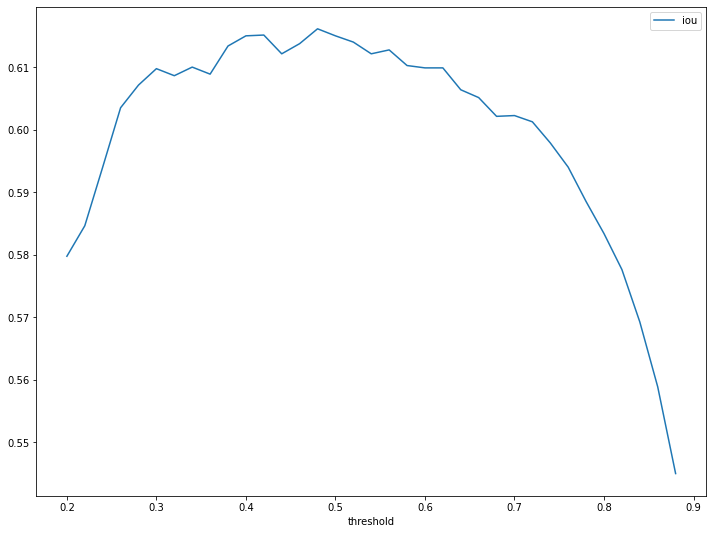

In [29]:
# Plot IoU values over threshold range.
df_iou_resnet.plot(x='threshold', y='iou')

In [30]:
input_size = (224, 224, 3)

# UNet-VGGモデルの確認
K.clear_session()
model = unet_vgg(
    input_size, decoder_block_simple, weights='imagenet')
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
____________________________________________________________________________________________

In [31]:
for l in model.layers:
  print(l.trainable) 

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [32]:
# メモリ使用量確認
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7413 sha256=94014ef6c55d52c6658ea7d609fc4186be9de35886776325bc4e4f9559f34b7f
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 6.8 GB  | Proc size: 9.3 GB
GPU RAM Free: 3013MB | Used: 8428MB | Util  74% | Total 11441MB


In [33]:
# RAMがやばいので使わないmodelを削除(ResourceExhaustedError)
#del model, base_model, model_depth
#gc.collect()
#-> ダメっぽいのでrestart kernel
# -> が、ダメ
#  -> メモリを無駄に確保しない設定にしてみる 
#config = tf.ConfigProto()
#config.gpu_options.allow_growth = True
printm()

K.clear_session()

# VGG版　ResNet版と比較したい
model_depth_vgg = unet_vgg(
    input_size, decoder_block_bottleneck, weights='imagenet',
    loss_func=bce_dice_loss, metrics_list=[my_iou_metric],
    use_lovash=False)
print(model_depth_vgg.summary())


model_checkpoint = ModelCheckpoint(
    'unet_vgg.h5' ,monitor='val_my_iou_metric', mode='max',
    save_best_only=True, save_weights_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(
    monitor='val_my_iou_metric',
    mode='max',
    factor=0.5, 
    patience=5, 
    min_lr=0.0001, 
    verbose=1)


epochs = 10 # 25
#batch_size = 16
batch_size = 8 # バッチサイズを半分にしてみる

history = model_depth_vgg.fit(X_tr, y_tr,
                    validation_data=[X_val, y_val], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[model_checkpoint,reduce_lr], 
                    verbose=1)

Gen RAM Free: 6.8 GB  | Proc size: 9.3 GB
GPU RAM Free: 3013MB | Used: 8428MB | Util  74% | Total 11441MB
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]  

In [34]:
val_preds_vgg = model_depth_vgg.predict(X_val, batch_size=16)

y_val_pred_vgg = np.asarray(list(map(lambda x: cv2.resize(x, (101, 101)), val_preds_vgg)))
y_val_true = np.asarray(list(map(lambda x: cv2.resize(x, (101, 101)), y_val)))

In [35]:
thresholds = np.arange(0.2, 0.9, 0.02)

ious = np.array(
    [iou_metric_batch(y_val_true,
                      np.int32(y_val_pred_vgg > threshold)) for threshold in tqdm(thresholds)])



  0%|          | 0/35 [00:00<?, ?it/s]

  3%|▎         | 1/35 [00:01<00:54,  1.59s/it]

  6%|▌         | 2/35 [00:03<00:52,  1.60s/it]

  9%|▊         | 3/35 [00:04<00:51,  1.61s/it]

 11%|█▏        | 4/35 [00:06<00:50,  1.61s/it]

 14%|█▍        | 5/35 [00:08<00:48,  1.61s/it]

 17%|█▋        | 6/35 [00:09<00:46,  1.62s/it]

 20%|██        | 7/35 [00:11<00:45,  1.62s/it]

 23%|██▎       | 8/35 [00:12<00:43,  1.61s/it]

 26%|██▌       | 9/35 [00:14<00:41,  1.61s/it]

 29%|██▊       | 10/35 [00:16<00:40,  1.61s/it]

 31%|███▏      | 11/35 [00:17<00:38,  1.62s/it]

 34%|███▍      | 12/35 [00:19<00:37,  1.62s/it]

 37%|███▋      | 13/35 [00:21<00:35,  1.62s/it]

 40%|████      | 14/35 [00:22<00:33,  1.61s/it]

 43%|████▎     | 15/35 [00:24<00:32,  1.61s/it]

 46%|████▌     | 16/35 [00:25<00:30,  1.61s/it]

 49%|████▊     | 17/35 [00:27<00:28,  1.60s/it]

 51%|█████▏    | 18/35 [00:29<00:27,  1.60s/it]

 54%|█████▍    | 19/35 [00:30<00:25,  1.61s/it]

 57%|█████▋    | 20/35 [00:32<00:24,

In [36]:
df_iou_vgg = pd.DataFrame(thresholds, columns=['threshold'])
df_iou_vgg['iou'] = ious

# Get index of best IoU
best_index_vgg = df_iou_vgg['iou'].idxmax()
print('Best IoU: {:.4f} at threshold: {:.3f}'.format(
    df_iou_vgg.iou[best_index_vgg], df_iou_vgg.threshold[best_index_vgg]))

# Describe IoU DF
df_iou_vgg.describe()

Best IoU: 0.6278 at threshold: 0.880


,threshold,iou
count,35.000000,35.000000
mean,0.540000,0.577936
std,0.204939,0.038706
min,0.200000,0.497125
25%,0.370000,0.545563
50%,0.540000,0.585000
75%,0.710000,0.611438
max,0.880000,0.627750


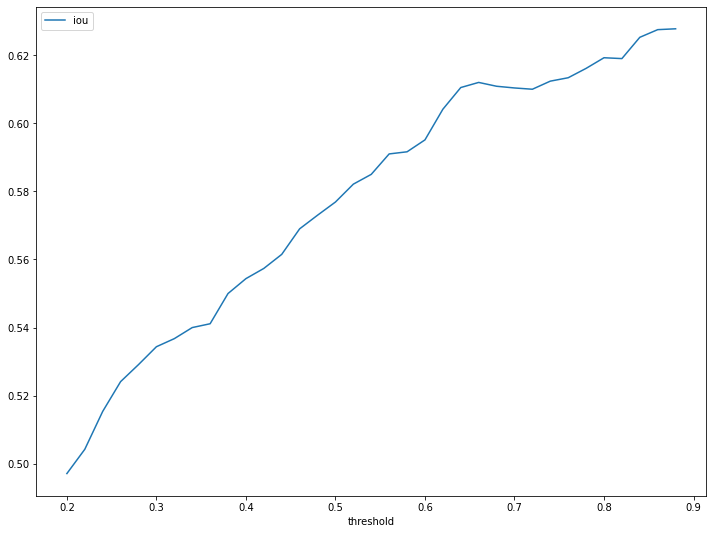

In [37]:
# Plot IoU values over threshold range.
df_iou_vgg.plot(x='threshold', y='iou')

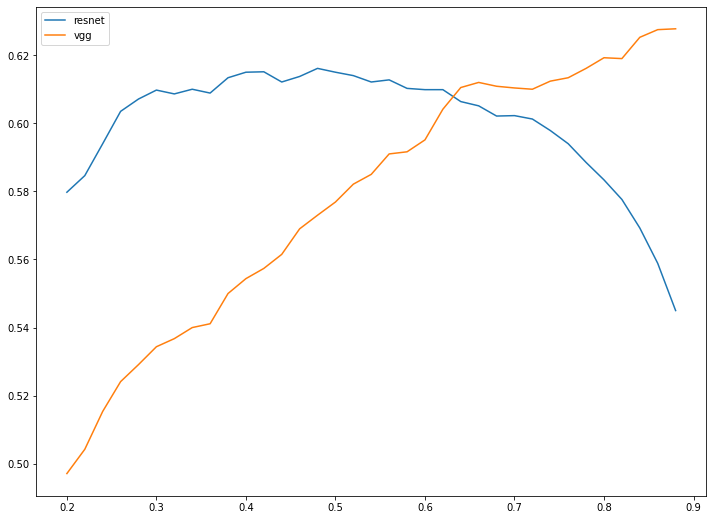

In [43]:
#比較
plt.plot(df_iou_resnet['threshold'], df_iou_resnet['iou'], label='resnet')
plt.plot(df_iou_vgg['threshold'], df_iou_vgg['iou'], label='vgg')
plt.legend()
plt.show()

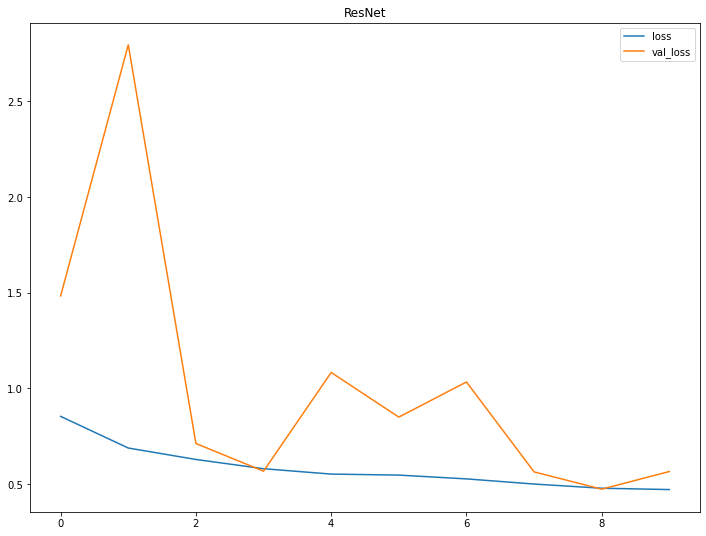

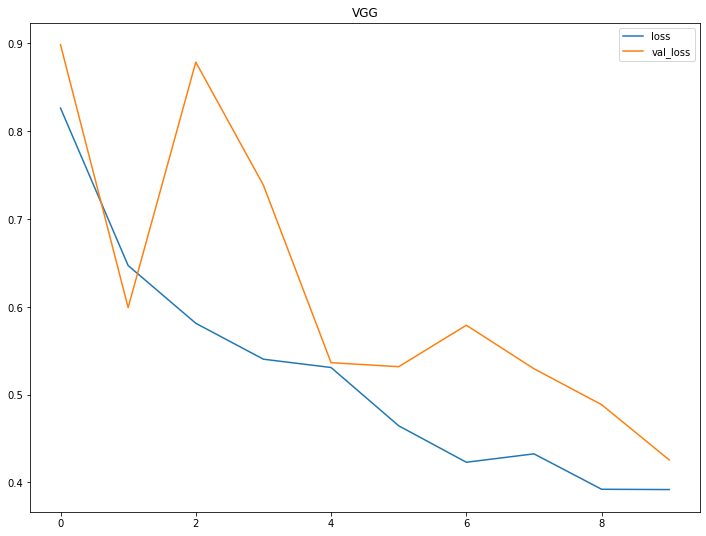

In [48]:
plt.title('ResNet')
plt.plot(history_resnet.history['loss'], label='loss')
plt.plot(history_resnet.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

plt.title('VGG')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()